<a href="https://colab.research.google.com/github/xRAFPx/AAII/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
!pip install livelossplot

In [0]:
!pip install livelossplot

In [0]:
import requests
import json
import csv
import string
import io
import pandas as pd
from tempfile import NamedTemporaryFile
import shutil
from datetime import date
import datetime
import os.path
from os import path
import re
import xlrd
import math
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from getpass import getpass
import geopandas
from functools import reduce
from livelossplot import PlotLossesKeras, PlotLossesKerasTF
from keras.callbacks import ModelCheckpoint
from livelossplot.tf_keras import PlotLossesCallback

# Variáveis

Variáveis utilizadas no decorrer do trabalho

In [0]:
datasetCOVID = 'https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv'
dicoAPI = "https://api.ipma.pt/open-data/distrits-islands.json"
climateAPI = 'https://api.ipma.pt/open-data/observation/climate/'

In [0]:
folder = '/content/drive/My Drive/Colab Notebooks/AII Project'
gitFolder = '/content/AAII/Data'
datasetDeaths = folder + '/Deaths/Portugal_Deaths.xlsx'
mapPath = folder + '/Map/portugal_continental.shp'
deaths_filepath = folder + '/Deaths/yearly_deaths.csv'
weather_filepath = folder +'/Weather'
daily_weather_filepath = folder + '/Daily Weather/'
norte_death_data = death_folder + '/Dados_SICO_ARSNorte.csv'
centro_death_data = death_folder + '/Dados_SICO_ARSCentro.csv'
lvt_death_data = death_folder + '/Dados_SICO_ARSLVT.csv'
alentejo_death_data = death_folder + '/Dados_SICO_ARSAlentejo.csv'
algarve_death_data = death_folder + '/Dados_SICO_ARSAlgarve.csv'
acores_death_data = death_folder + '/Dados_SICO_RAAcores.csv'
madeira_death_data = death_folder + '/Dados_SICO_RAMadeira.csv'

In [0]:
if path.exists(folder):
  print("No directory error")
else:
  #Create a new directory (a folder) in your Drive
  os.mkdir(folder)
  print("Directory created")


No directory error


# Dados do COVID-19 

Dados do COVID-19 obtidos a partir do link https://github.com/dssg-pt/covid19pt-data/blob/master/data.csv

In [0]:
def read_dataset(url):
  df = pd.read_csv(url, parse_dates=[0], index_col=[0], infer_datetime_format=True)
  return df.fillna(value=0)

Obter dados relativos ás regiões (casos confirmados e óbitos) e fazer o log desses dados e guardar em features. Para impedir valores de -inf no resultado do logaritmo, apenas é feito o log em valores superiores a 0.


In [0]:
def prepare_dataset_regions(df):
  df_aux = df[['confirmados_arsnorte',	'confirmados_arscentro',	'confirmados_arslvt',	
               'confirmados_arsalentejo',	'confirmados_arsalgarve',	'confirmados_acores',	'confirmados_madeira',
               'obitos_arsnorte',	'obitos_arscentro',	'obitos_arslvt',	'obitos_arsalentejo',	'obitos_arsalgarve',	
               'obitos_acores',	'obitos_madeira'
               ]].copy()
               
  df_aux['confirmados_arsnorte_log'] = np.where(df_aux['confirmados_arsnorte']>0, np.log(df_aux['confirmados_arsnorte']), 0)
  df_aux['confirmados_arscentro_log'] = np.where(df_aux['confirmados_arscentro']>0, np.log(df_aux['confirmados_arscentro']), 0)
  df_aux['confirmados_arslvt_log'] = np.where(df_aux['confirmados_arslvt']>0, np.log(df_aux['confirmados_arslvt']), 0)
  df_aux['confirmados_arsalentejo_log'] = np.where(df_aux['confirmados_arsalentejo']>0, np.log(df_aux['confirmados_arsalentejo']), 0)
  df_aux['confirmados_arsalgarve_log'] = np.where(df_aux['confirmados_arsalgarve']>0, np.log(df_aux['confirmados_arsalgarve']), 0)
  df_aux['confirmados_acores_log'] = np.where(df_aux['confirmados_acores']>0, np.log(df_aux['confirmados_acores']), 0)
  df_aux['confirmados_madeira_log'] = np.where(df_aux['confirmados_madeira']>0, np.log(df_aux['confirmados_madeira']), 0)

  df_aux['obitos_arsnorte_log'] = np.where(df_aux['obitos_arsnorte']>0, np.log(df_aux['obitos_arsnorte']), 0)
  df_aux['obitos_arscentro_log'] = np.where(df_aux['obitos_arscentro']>0, np.log(df_aux['obitos_arscentro']), 0)
  df_aux['obitos_arslvt_log'] = np.where(df_aux['obitos_arslvt']>0, np.log(df_aux['obitos_arslvt']), 0)
  df_aux['obitos_arsalentejo_log'] = np.where(df_aux['obitos_arsalentejo']>0, np.log(df_aux['obitos_arsalentejo']), 0)
  df_aux['obitos_arsalgarve_log'] = np.where(df_aux['obitos_arsalgarve']>0, np.log(df_aux['obitos_arsalgarve']), 0)
  df_aux['obitos_acores_log'] = np.where(df_aux['obitos_acores']>0, np.log(df_aux['obitos_acores']), 0)
  df_aux['obitos_madeira_log'] = np.where(df_aux['obitos_madeira']>0, np.log(df_aux['obitos_madeira']), 0)

  return df_aux

Obter número de óbitos por COVID-19 para posterior análise com o número médio de mortes nos últimos anos em Portugal

In [0]:
def prepare_dataset_deaths(df):
  df_aux = df[['obitos']].copy()
  df_aux['obitos'] = np.where(df_aux['obitos']>0, np.log(df_aux['obitos']), 0)
  df_aux_aux = df_aux.copy()
  df_aux_aux['month_year'] = df_aux_aux.index.to_period("M")
  first_date = df_aux_aux.head(1)
  last_date = df_aux_aux.tail(1)
  first_year = first_date.index.year.item()
  last_year = last_date.index.year.item()
  df_aux_aux = df_aux_aux.groupby(df_aux_aux.month_year).sum().astype(np.int64)
  start_date = '01-01-' + str(first_year)
  end_date = '31-12-' + str(last_year)
  idx = pd.period_range(start_date, end_date, freq="M")
  df_aux_aux = df_aux_aux.reindex(idx, fill_value=0)
  df_aux_aux['month'] = df_aux_aux.index.month
  return df_aux, df_aux_aux

In [0]:
dataset = read_dataset(datasetCOVID)

In [0]:
df_region = prepare_dataset_regions(dataset)
# pd.set_option('display.max_rows', df_region.shape[0]+1)
# print(df_region)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [0]:
df_death, df_death_aux = prepare_dataset_deaths(dataset)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# LSTM

In [0]:
#Scale the data (values will be between -1 and 1) to increase the training speed and performance of the model
#the normalization is between -1 and 1 because of the tanh function used to build the model
def data_normalization(df, normalization_range=(-1, 1)):
  scaler = MinMaxScaler(feature_range = normalization_range)
  df[['confirmados_arsnorte']] = scaler.fit_transform(df[['confirmados_arsnorte']])
  df[['confirmados_arscentro']] = scaler.fit_transform(df[['confirmados_arscentro']])
  df[['confirmados_arslvt']] = scaler.fit_transform(df[['confirmados_arslvt']])
  df[['confirmados_arsalentejo']] = scaler.fit_transform(df[['confirmados_arsalentejo']])
  df[['confirmados_arsalgarve']] = scaler.fit_transform(df[['confirmados_arsalgarve']])
  df[['confirmados_acores']] = scaler.fit_transform(df[['confirmados_acores']])
  df[['confirmados_madeira']] = scaler.fit_transform(df[['confirmados_madeira']])
  return scaler

In [0]:
scaler = data_normalization(df_region)

In [0]:
def get_confirmed_regions(df):
  df_norte = df[['confirmados_arsnorte']].copy()
  df_centro = df[['confirmados_arscentro']].copy()
  df_lvt = df[['confirmados_arslvt']].copy()
  df_alentejo = df[['confirmados_arsalentejo']].copy()
  df_algarve = df[['confirmados_arsalgarve']].copy()
  df_acores = df[['confirmados_acores']].copy()
  df_madeira = df[['confirmados_madeira']].copy()
  return df_norte, df_centro, df_lvt, df_alentejo, df_algarve, df_acores, df_madeira

In [0]:
df_norte, df_centro, df_lvt, df_alentejo, df_algarve, df_acores, df_madeira = get_confirmed_regions(df_region)

In [0]:
valid_test_percent = 0.1 #10% para teste e 10% para validação
df_region_valid_test_size = int(np.round(valid_test_percent * df_region.shape[0]))
df_region_train_size = df_region.shape[0] - df_region_valid_test_size*2

In [0]:
df_norte_valid = df_norte[df_region_train_size:df_region_train_size + df_region_valid_test_size]
df_norte_test = df_norte[df_region_train_size + df_region_valid_test_size :]
df_norte_train = df_norte[:df_region_train_size]

In [0]:
def build_supervised(df, timesteps):
	data = df.values
	X, y = list(), list()
	dataset_size = len(data)
	for curr_pos in range(dataset_size):
		input_index =  curr_pos + timesteps
		label_index = input_index + 1
		if label_index < dataset_size:
			X.append(data[curr_pos:input_index, :])
			y.append(data[input_index:label_index, 0])
	return np.array(X).astype('float32'), np.array(y).astype('float32')

In [0]:
timesteps = 5

In [0]:
# X_norte, y_norte = build_supervised(df_norte, timesteps)
# X_centro, y_centro = build_supervised(df_centro, timesteps)
# X_lvt, y_lvt = build_supervised(df_lvt, timesteps)
# X_alentejo, y_alentejo = build_supervised(df_alentejo, timesteps)
# X_algarve, y_algarve = build_supervised(df_algarve, timesteps)
# X_acores, y_acores = build_supervised(df_acores, timesteps)
# X_madeira, y_madeira = build_supervised(df_madeira, timesteps)

In [0]:
# print(X_norte.shape)
#80 grupos (visto no dia 22 maio), cada 1 com timesteps dias, em 1 linha
#16 maio até 20 maio para prever 21 no caso de timesteps = 5 (por isso é que só são 80 grupos em 85 dias totais)
# print(y_norte.shape)
#resultado do dia seguinte ao de cada grupo

In [0]:
X_norte_train, y_norte_train = build_supervised(df_norte_train, timesteps)
X_norte_test, y_norte_test = build_supervised(df_norte_test, timesteps)
X_norte_valid, y_norte_valid = build_supervised(df_norte_valid, timesteps)

In [0]:
print(X_norte_train.shape, y_norte_train.shape)
print(X_norte_test.shape, y_norte_test.shape)
print(X_norte_valid.shape, y_norte_valid.shape)

(62, 5, 1) (62, 1)
(3, 5, 1) (3, 1)
(3, 5, 1) (3, 1)


Root-mean-square-error (RMSE) é uma medida de desempenho padrão usada para fins de previsão de séries temporais.

In [0]:
def rmse(y_true, y_pred):
    #RMSE = tf.sqrt(tf.losses.mean_squared_error(y_pred, y_true))
    #RMSE = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_pred, y_true))))
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

In [0]:
def build_model_lstm(timesteps, features, h_neurons = 64, activation = 'tanh', dropout_rate = 0.4):
    # model = tf.keras.models.Sequential()
    # model.add(tf.keras.layers.LSTM(h_neurons, return_sequences=True, input_shape=(timesteps, features)))
    # model.add(tf.keras.layers.LSTM(int(h_neurons*2), return_sequences=True, dropout=dropout_rate))
    # model.add(tf.keras.layers.LSTM(int(h_neurons*4), return_sequences=False, dropout=dropout_rate))
    # model.add(tf.keras.layers.Dense(h_neurons, activation = activation))
    # model.add(tf.keras.layers.Dropout(dropout_rate))
    # model.add(tf.keras.layers.Dense(1, activation='linear'))

    # model = tf.keras.models.Sequential()
    # model.add(tf.keras.layers.LSTM(h_neurons, return_sequences=True, input_shape=(timesteps, features)))
    # model.add(tf.keras.layers.LSTM(int(h_neurons), return_sequences=True, dropout=dropout_rate))
    # model.add(tf.keras.layers.LSTM(int(h_neurons), return_sequences=True, dropout=dropout_rate))
    # model.add(tf.keras.layers.Dense(h_neurons, activation = activation))
    # model.add(tf.keras.layers.Dropout(dropout_rate))
    # model.add(tf.keras.layers.Dense(1, activation='linear'))

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(h_neurons, return_sequences=True, input_shape=(timesteps, features)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.LSTM(int(h_neurons*2), return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.LSTM(int(h_neurons*4), return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.LSTM(int(h_neurons), return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(h_neurons, activation = activation))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(
		loss = rmse,
		optimizer = tf.keras.optimizers.Adam(),
		metrics = ['mae', rmse]
	)
    print(model.summary())
    tf.keras.utils.plot_model(model, 'covid19_model.png', show_shapes=True)
    return model

In [0]:
epochs = 200
univariate = 1
batch_size = 16
verbose = 1
min_lr = 0.00002

In [0]:
model_norte = build_model_lstm(timesteps, univariate, h_neurons = 50, dropout_rate = 0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10400     
_________________________________________________________________
dropout (Dropout)            (None, 5, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 100)            60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 200)            240800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 200)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 50)             5

In [0]:
def train_model(model, model_id):
  checkpoint_filepath = "/content/drive/My Drive/Colab Notebooks/best_weights_" + str(model_id) + ".hdf5"
  model_filepath = '/content/drive/My Drive/Colab Notebooks/model_' + str(model_id) + '.h5'
  checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor = 'val_loss', verbose=1, save_best_only=True)
  lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 50, min_lr = min_lr)
  history = model.fit(X_norte_train, y_norte_train, epochs = epochs, batch_size = batch_size, shuffle = False, verbose = 0, callbacks = [PlotLossesKerasTF(), checkpointer, lr], validation_data=(X_norte_valid, y_norte_valid))
  model.load_weights(checkpoint_filepath)
  model.save(model_filepath)
  return history

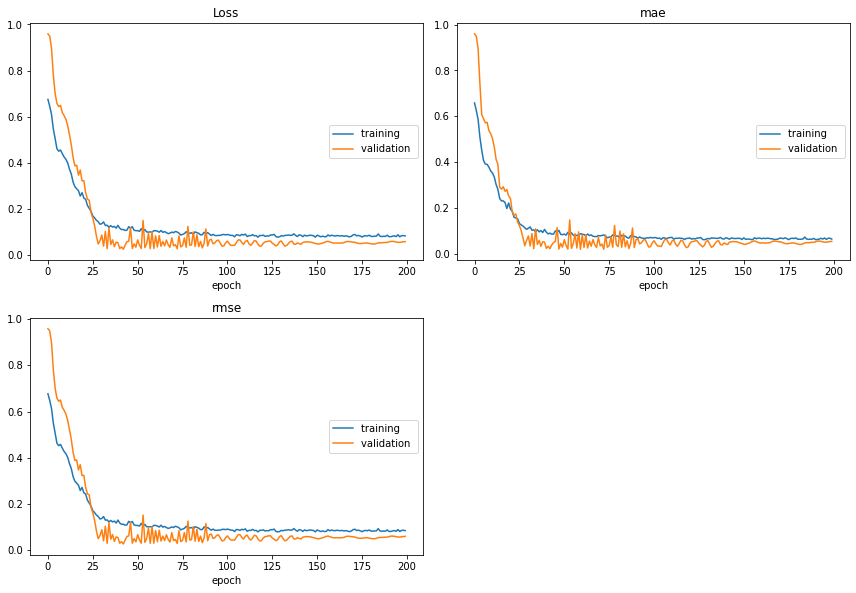

Loss
	training         	 (min:    0.078, max:    0.676, cur:    0.084)
	validation       	 (min:    0.026, max:    0.959, cur:    0.059)
mae
	training         	 (min:    0.062, max:    0.658, cur:    0.065)
	validation       	 (min:    0.021, max:    0.959, cur:    0.055)
rmse
	training         	 (min:    0.078, max:    0.677, cur:    0.084)
	validation       	 (min:    0.026, max:    0.959, cur:    0.059)

Epoch 00200: val_loss did not improve from 0.02608


In [0]:
history_norte = train_model(model_norte, 1)

In [0]:
def build_model_gru(timesteps, features, h_neurons = 64, activation = 'tanh', dropout_rate = 0.5):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.GRU(h_neurons, return_sequences=True, input_shape=(timesteps, features)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.GRU(int(h_neurons*2), return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.GRU(int(h_neurons*4), return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.GRU(int(h_neurons), return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(h_neurons, activation = activation))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(
		loss = rmse,
		optimizer = tf.keras.optimizers.Adam(),
		metrics = ['mae', rmse]
	)
    print(model.summary())
    tf.keras.utils.plot_model(model, 'covid19_model.png', show_shapes=True)
    return model

In [0]:
model_norte_GRU = build_model_gru(timesteps, univariate, h_neurons = 50, dropout_rate = 0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5, 50)             7950      
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 50)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 5, 100)            45600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 100)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 5, 200)            181200    
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 200)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 5, 50)            

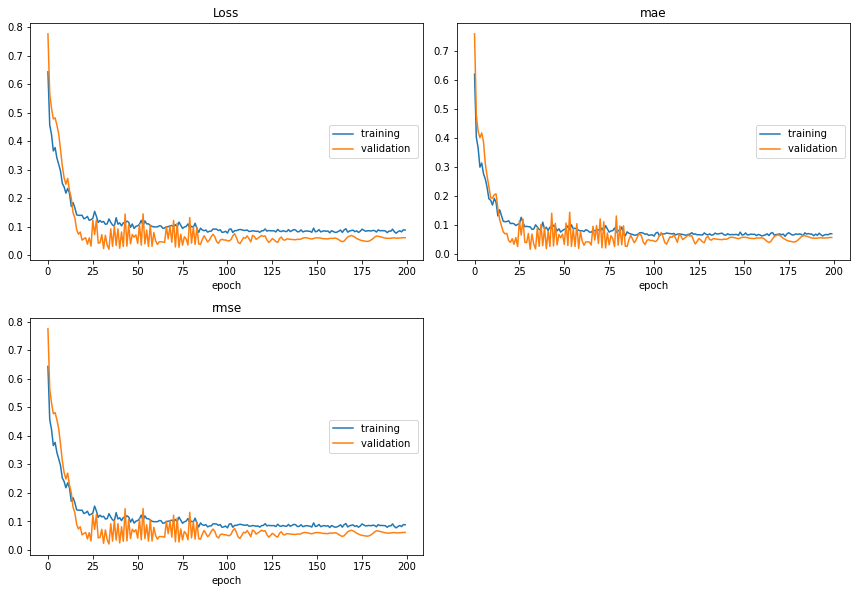

Loss
	training         	 (min:    0.077, max:    0.676, cur:    0.088)
	validation       	 (min:    0.021, max:    0.959, cur:    0.062)
mae
	training         	 (min:    0.061, max:    0.658, cur:    0.070)
	validation       	 (min:    0.017, max:    0.959, cur:    0.057)
rmse
	training         	 (min:    0.078, max:    0.677, cur:    0.088)
	validation       	 (min:    0.021, max:    0.959, cur:    0.062)

Epoch 00200: val_loss did not improve from 0.02090


In [0]:
history_norte_gru = train_model(model_norte_GRU, 2)

In [0]:
def build_model_lstm_gru(timesteps, features, h_neurons = 50, activation = 'tanh', dropout_rate = 0.2):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=h_neurons, return_sequences=True, recurrent_dropout=dropout_rate, input_shape=(timesteps, features)))
    model.add(tf.keras.layers.LSTM(units=h_neurons, return_sequences=True, recurrent_dropout=dropout_rate, input_shape=(timesteps, features)))

    model.add(tf.keras.layers.GRU(units=h_neurons, return_sequences=True, recurrent_dropout=dropout_rate, input_shape=(timesteps, features)))
    model.add(tf.keras.layers.GRU(units=h_neurons, return_sequences=True, recurrent_dropout=dropout_rate, input_shape=(timesteps, features)))
    
    model.add(tf.keras.layers.Dense(h_neurons, activation = activation))
    model.add(tf.keras.layers.Dense(1, activation = 'linear'))

    model.compile(
		loss = rmse,
		optimizer = tf.keras.optimizers.Adam(),
		metrics = ['mae', rmse]
	)
    print(model.summary())
    tf.keras.utils.plot_model(model, 'covid19_model.png', show_shapes=True)
    return model

In [0]:
model_norte_LSTM_GRU = build_model_lstm_gru(timesteps, univariate, h_neurons = 50, dropout_rate = 0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 50)             10400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 50)             20200     
_________________________________________________________________
gru_4 (GRU)                  (None, 5, 50)             15300     
_________________________________________________________________
gru_5 (GRU)                  (None, 5, 50)             15300     
_________________________________________________________________
dense_4 (Dense)              (None, 5, 50)             2550      
_________________________________________________________________
dense_5 (Dense)              (None, 5, 1)              51        
Total params: 63,801
Trainable params: 63,801
Non-trainable params: 0
__________________________________________________

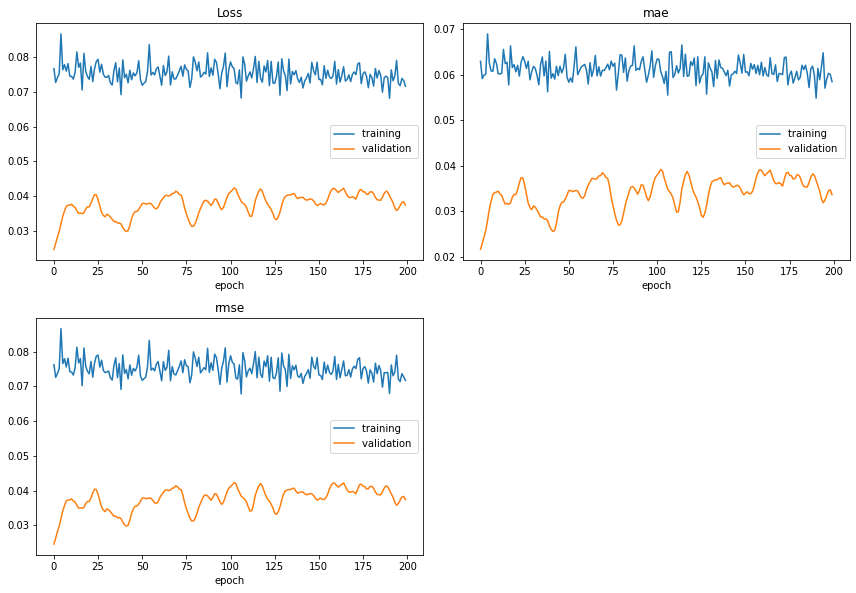

Loss
	training         	 (min:    0.060, max:    0.676, cur:    0.072)
	validation       	 (min:    0.021, max:    0.962, cur:    0.037)
mae
	training         	 (min:    0.049, max:    0.658, cur:    0.058)
	validation       	 (min:    0.017, max:    0.962, cur:    0.034)
rmse
	training         	 (min:    0.060, max:    0.677, cur:    0.072)
	validation       	 (min:    0.021, max:    0.962, cur:    0.037)

Epoch 00200: val_loss did not improve from 0.02459


In [0]:
history_norte_gru_lstm = train_model(model_norte_LSTM_GRU, 3)

In [0]:
def forecast(model, df, timesteps, multisteps, scaler):
	input_seq = df[-timesteps:].values
	inp = input_seq
	predictions = list()
	for step in range(1, multisteps + 1):
		inp = inp.reshape(1, timesteps, 1)
		yhat = model.predict(inp, verbose = verbose)
        #reverse the scaling (from (-1,1) to "normal" scaling
        #using the scaler that normalized the values we can obtain the values of predicted cases
		yhat_inversed = scaler.inverse_transform(yhat)
		predictions.append(yhat_inversed[0][0])
        #add prediction to input
		inp = np.append(inp[0], yhat)
        #eliminate older timestep
		inp = inp[-timesteps:]
	return predictions

In [0]:
import matplotlib.pyplot as plt

def make_plot(n_time_step,predictions,true_values,x_axis):

  plt.figure(figsize=(20,5))
  
  i = n_time_step - 1

  x_axis = np.asarray(x_axis)

  x_axis_train = x_axis[:len(x_axis)-i][-25:]
  y_train = corrected_labels[:len(corrected_labels)-i][-25:]
  
  
  y_axis_predictions = np.append(y_train,np.asarray(predictions),axis=0)
  y_axis_true_values = np.append(y_train,np.asarray(true_values),axis=0)
  

  plt.plot(x_axis[-i],y_axis_true_values,'b')
  plt.plot(x_axis[-i],y_axis_predictions,'r')
  plt.plot(x_axis_train,y_train) 

  plt.title("Evolução do COVID-19")
  plt.xlabel("Dia")
  plt.xticks(rotation=90)
  plt.ylabel("Número de casos confirmados")
  plt.legend([
            'Previsão',
            'Real',
            'Dados de treino'
            ],loc = 'upper left')
  
  plt.legend
  plt.show()

make_plot(1,n_time_step,predictions,true_values,x_axis)

NameError: ignored

In [0]:
# !git add "/content/AAII"
# !git commit -m "updated data folder"

In [0]:
# !git push origin master

BIBLIOGRAFIA
*   https://medium.com/@navan0/how-to-push-files-into-github-from-google-colab-379fd0077aa8
*   https://www.interviewqs.com/ddi_code_snippets/extract_month_year_pandas
*   https://www.dataquest.io/blog/python-datetime-tutorial/
*   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html
*   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html
*   https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.PeriodIndex.html
*   http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
*https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru

